<a href="https://colab.research.google.com/github/SrivenkateswaraRao/Research-Project/blob/master/Pest_Classifier_Inception_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:

import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


In [9]:
import os
from os import listdir
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [33]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [10]:
import tensorflow as tf 
import numpy as np
import keras as ks 


Using TensorFlow backend.


In [11]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

In [34]:
file_list = drive.ListFile(
    {'q': "'1MzurTS9xeNSss_hYgko4ATZ5qNVn45ty' in parents"}).GetList()

for f in file_list:
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = f['title']
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

title: LABELS.zip, id: 1dYxm-yV2sCOxiQQSvzRY6-gKtlfo0WLH
downloading to LABELS.zip
title: GREENPATROL_DB_V1.0.zip, id: 1wJw1Ci1OTUoKjiiT3lwWqwonTunGPMB1
downloading to GREENPATROL_DB_V1.0.zip
title: predefined_classes.txt, id: 1XQkqHvepaPEXxJ5XXSZmMMk9qrxTOSzJ
downloading to predefined_classes.txt


In [ ]:
file_list = drive.ListFile(
    {'q': "'1lc25fXo3qb8OIV_4v-UygT3GFS0s7JBK' in parents"}).GetList()

for f in file_list:
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = f['title']
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

title: LABELS_Test.zip, id: 1rs9OZDuvy4XkV89PMx4F6dZTSJe5gbCI
downloading to LABELS_Test.zip
title: GREENPATROL_DB_V1.0_Test.zip, id: 15scYv3E4bmMB9pkbrumhea6EhhfxvLBL
downloading to GREENPATROL_DB_V1.0_Test.zip


In [ ]:
#------------------------------- Load Train Data ----------------------------------------------#
download_Pests_Test = drive.CreateFile({'id': '15scYv3E4bmMB9pkbrumhea6EhhfxvLBL'})
download_Annotations_Test = drive.CreateFile({'id': '1rs9OZDuvy4XkV89PMx4F6dZTSJe5gbCI'})
!unzip LABELS_Test.zip -d '/Tomato-Pests'
!unzip GREENPATROL_DB_V1.0_Test.zip -d '/Tomato-Pests'


In [36]:
download_Pests_Validate = drive.CreateFile({'id': '1wJw1Ci1OTUoKjiiT3lwWqwonTunGPMB1'})
download_Annotations_Validate = drive.CreateFile({'id': '1dYxm-yV2sCOxiQQSvzRY6-gKtlfo0WLH'})
!unzip LABELS_Validation.zip -d '/Tomato-Pests/Validation'
!unzip GREENPATROL_DB_V1.0_Validation.zip -d '/Tomato-Pests/Validation'

unzip:  cannot find or open LABELS_Validation.zip, LABELS_Validation.zip.zip or LABELS_Validation.zip.ZIP.
unzip:  cannot find or open GREENPATROL_DB_V1.0_Validation.zip, GREENPATROL_DB_V1.0_Validation.zip.zip or GREENPATROL_DB_V1.0_Validation.zip.ZIP.


In [12]:
class_object = {0 : 'egg_wf' ,
                1 : 'egg_bt', 2 : 'egg_ta', 3 : 'wf', 4 : 'bt', 5 : 'ta', 6 : 'ta_maps', 7 : 'ta_larvae', 8 : 'ta_maps+larvae', 9 : 'tomato'}

In [13]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [14]:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [27]:

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [16]:
base_dir = '/Tomato-Pests'
train_dir = "/Tomato-Pests/Train"
validation_dir = "/Tomato-Pests/Test"


In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [18]:
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [19]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     


Found 21474 images belonging to 5 classes.


In [20]:
# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 2800 images belonging to 5 classes.


In [ ]:
#------------------------------------Create Folder Structure--------------------------------------------#
def createFolder(ParentFolder):
  directory_Train = "Train"
  directory_Test = "Test"
  parent_dir = "/"+ParentFolder+"/"
  path_Train = os.path.join(parent_dir, directory_Train)
  path_Test = os.path.join(parent_dir, directory_Test)
  os.mkdir(path_Train) 
  os.mkdir(path_Test)   

In [ ]:
createFolder('Tomato-Pests')

In [ ]:
  
  directory_Train = "Tomato-Pests/Train"
  directory_Test = "Tomato-Pests/Test"
  
  directory_wf = "egg_wf"
  directory_bt = "egg_bt"
  directory_egg_wf = "wf"
  directory_egg_bt = "bt"
  directory_tomato = "tomato"
 
    #-----------------Training Foder Structure ---------------------------#
  path_wf_Train = os.path.join("/" + directory_Train + "/", directory_wf)
  path_bt_Train = os.path.join("/" + directory_Train + "/", directory_bt) 
  path_egg_wf_Train = os.path.join("/" + directory_Train + "/", directory_egg_wf) 
  path_egg_bt_Train = os.path.join("/" + directory_Train + "/", directory_egg_bt) 
  path_tomato_Train = os.path.join("/" + directory_Train + "/", directory_tomato) 

  os.mkdir(path_wf_Train)
  os.mkdir(path_bt_Train) 
  os.mkdir(path_egg_wf_Train) 
  os.mkdir(path_egg_bt_Train) 
  os.mkdir(path_tomato_Train) 

  #------------------- Testing Folder Structure -------------------------#
  path_wf_Test = os.path.join("/" + directory_Test + "/", directory_wf)
  path_bt_Test = os.path.join("/" + directory_Test + "/", directory_bt) 
  path_egg_wf_Test = os.path.join("/" + directory_Test + "/", directory_egg_wf) 
  path_egg_bt_Test = os.path.join("/" + directory_Test + "/", directory_egg_bt) 
  path_tomato_Test = os.path.join("/" + directory_Test + "/", directory_tomato)

  os.mkdir(path_wf_Test)
  os.mkdir(path_bt_Test) 
  os.mkdir(path_egg_wf_Test) 
  os.mkdir(path_egg_bt_Test) 
  os.mkdir(path_tomato_Test) 

In [1]:
from google.colab import files
files.upload() 

Saving CreatePestImageData_Inception_V3.py to CreatePestImageData_Inception_V3.py


{'CreatePestImageData_Inception_V3.py': b'# -*- coding: utf-8 -*-\r\n"""createImageDataset.ipynb\r\n\r\nAutomatically generated by Colaboratory.\r\n\r\nOriginal file is located at\r\n    https://colab.research.google.com/drive/1FXiYKCQ-jtbL_O29BQb2Xy1bBd2inM9q\r\n"""\r\n\r\nfrom os import listdir\r\nimport numpy as np\r\nimport xml.etree.ElementTree as ET\r\nimport cv2\r\nimport tensorflow as tf \r\nimport os \r\n\r\n\r\nclass createImageDataset(object):\r\n    \r\n    def __init__(self, class_map=None):\r\n        self.image_info = []\r\n        self.trainX = []\r\n        self.trainY = []\r\n        self.testX = []\r\n        self.testY = []\r\n            \r\n    def add_image_info(self , image_array , image_path , image_id , object_id , class_name , class_id):\r\n        \r\n        image_info_ = {\'object_id\': image_id,\r\n                       \'object_class\': class_name,\r\n                       \'image_path\': image_path,\r\n                       \'image_array\': image_arr

In [2]:
import CreatePestImageData_Inception_V3 as Imagedataset

In [4]:
dataSet = Imagedataset.createImageDataset()

In [ ]:
 dataSet.prepare_dataset('/Tomato-Pests/LABELS/' , class_object,   '/Tomato-Pests/GREENPATROL_DB_V1.0/','Train')

In [ ]:
 dataSet.prepare_dataset('/Tomato-Pests/LABELS_Test/' , class_object,   '/Tomato-Pests/GREENPATROL_DB_V1.0_Test/','Test')

In [ ]:
import os, re, os.path
mypath = "/Tomato-Pests/bt"
for root, dirs, files in os.walk(mypath):
    for file in files:
        os.remove(os.path.join(root, file))

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [22]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [30]:
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 25,
            epochs = 50,
            validation_steps = 20,
            verbose = 1,
            callbacks=[callbacks])


Epoch 1/50
25/25 [==============================] - 42s 2s/step - loss: 0.9318 - acc: 0.7424 - val_loss: 0.5573 - val_acc: 0.7550
Epoch 2/50
25/25 [==============================] - 41s 2s/step - loss: 0.5537 - acc: 0.7868 - val_loss: 0.5219 - val_acc: 0.7985
Epoch 3/50
25/25 [==============================] - 41s 2s/step - loss: 0.5196 - acc: 0.7964 - val_loss: 0.5336 - val_acc: 0.8000
Epoch 4/50
25/25 [==============================] - 41s 2s/step - loss: 0.5146 - acc: 0.8000 - val_loss: 0.5158 - val_acc: 0.8000
Epoch 5/50
25/25 [==============================] - 41s 2s/step - loss: 0.5125 - acc: 0.7988 - val_loss: 0.5146 - val_acc: 0.8000
Epoch 6/50
25/25 [==============================] - 41s 2s/step - loss: 0.5099 - acc: 0.8000 - val_loss: 0.5196 - val_acc: 0.8000
Epoch 7/50
25/25 [==============================] - 41s 2s/step - loss: 0.5093 - acc: 0.8000 - val_loss: 0.5039 - val_acc: 0.8000
Epoch 8/50
25/25 [==============================] - 41s 2s/step - loss: 0.5085 - acc: 0.80

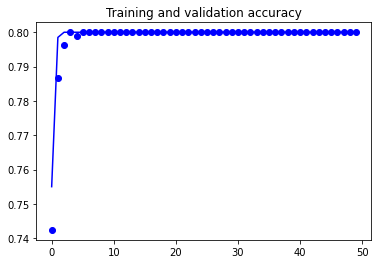

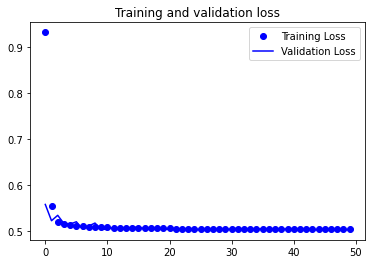

In [31]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
from google.colab import files

uploaded = files.upload()


In [ ]:
Creae the x_test
  x_test = []
  
  for i in tqdm(test_data['id'].values):
      img = cv2.imread('../input/dog-breed-identification/test/{}.jpg'.format(i))
      x_test.append(cv2.resize(img, (150, 150)))


# New Section